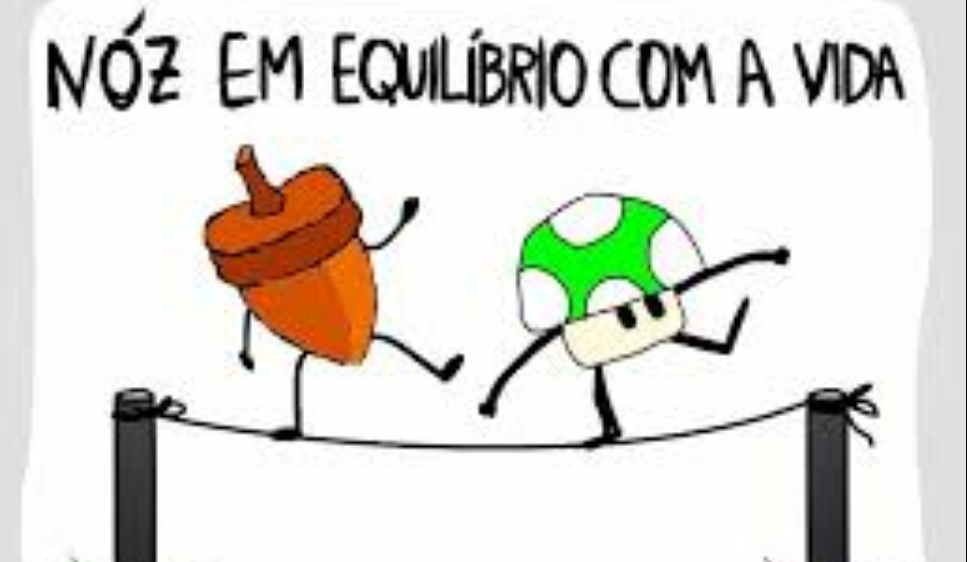

In [ ]:
#@title
%%capture
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R

Continuous version by Ian Danforth
"""

import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class ContinuousCartPoleEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 30.0
        self.tau = 0.02  # seconds between state updates
        self.min_action = -1.0
        self.max_action = 1.0

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds
        high = np.array([
            self.x_threshold * 2,
            np.finfo(np.float32).max,
            self.theta_threshold_radians * 2,
            np.finfo(np.float32).max])

        self.action_space = spaces.Box(
            low=self.min_action,
            high=self.max_action,
            shape=(1,)
        )
        self.observation_space = spaces.Box(-high, high)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / \
            (self.length * (4.0/3.0 - self.masspole * costheta * costheta / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        assert self.action_space.contains(action), \
            "%r (%s) invalid" % (action, type(action))
        # Cast action to float to strip np trappings
        force = self.force_mag * float(action)
        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state
        done = x < -self.x_threshold \
            or x > self.x_threshold \
            or theta < -self.theta_threshold_radians \
            or theta > self.theta_threshold_radians
        done = bool(done)

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn("""
You are calling 'step()' even though this environment has already returned
done = True. You should always call 'reset()' once you receive 'done = True'
Any further steps are undefined behavior.
                """)
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width /world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * 1.0
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen-polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth / 2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=(mode == 'rgb_array'))

    def close(self):
        if self.viewer:
            self.viewer.close()

# Inspecionando as entradas e saídas

In [ ]:

env = gym.make('CartPole-v1')


In [ ]:

# Examina as entradas e saídas
print('Estados: \n[position of cart, velocity of cart, angle of pole, rotation rate of pole]')
print(env.observation_space.low)
print(env.observation_space.high)
print('Ações:')
print(env.action_space.n)

Estados: 
[position of cart, velocity of cart, angle of pole, rotation rate of pole]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Ações:
2


# Q-learning

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')

# How much new info will override old info. 0 means nothing is learned, 1 means only most recent is considered, old knowledge is discarded
LEARNING_RATE = 0.1
# Between 0 and 1, mesue of how much we carre about future reward over immedate reward
DISCOUNT = 0.95
RUNS = 20000  # Number of iterations run
# SHOW_EVERY = 2000  # How often the current solution is rendered
UPDATE_EVERY = 100  # How often the current progress is recorded

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 600
END_EPSILON_DECAYING = 18000
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)


In [ ]:


# Discretizando o estado contínuo, e criando uma Q table
def create_bins_and_q_table():
  
#[position of cart, velocity of cart,  angle of pole, rotation rate of pole]
#[  -4.8000002e+00    -3.4028235e+38  -4.1887903e-01         -3.4028235e+38]
#[   4.8000002e+00    3.4028235e+38    4.1887903e-01          3.4028235e+38]

	numBins = 20
	obsSpaceSize = len(env.observation_space.high)

	# Get the size of each bucket
	bins = [
		np.linspace(-4.8, 4.8, numBins),
		np.linspace(-4, 4, numBins),
		np.linspace(-.418, .418, numBins),
		np.linspace(-4, 4, numBins)
	]
	qTable = np.random.uniform(low=-2, high=0, size=([numBins] * obsSpaceSize + [env.action_space.n]))
	print(qTable.shape)

	return bins, obsSpaceSize, qTable


In [ ]:

# Dado algum estado (continuo) - função retorna o estado discretizado
# ou seja, retorna o index do estado correspondente na Q-table
def get_discrete_state(state, bins, obsSpaceSize):
	stateIndex = []
	for i in range(obsSpaceSize):
		stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
	return tuple(stateIndex)


In [ ]:

bins, obsSpaceSize, qTable = create_bins_and_q_table()

previousCnt = []  # salva todos os scores
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metricas salvas para plotar o grafico apos treinamento

(20, 20, 20, 20, 2)


É uma Q-table de 5 dimensões, (temos 20x20x20x20x2 Q-values) = 16000

Diferente da aula anterior, onde eram 2 apenas, sendo :

1 - a posição do agente

2 - a ação



In [ ]:

#TREINAMENTO

for run in range(RUNS):
	discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
	done = False  # has the enviroment finished?
	cnt = 0  # how may movements cart has made

	while not done:
		# if run % SHOW_EVERY == 0:
			# env.render()  # if running RL comment this out

		cnt += 1
		# Caso random 0-1 seja maior q o epsilon, ele pega o melhor valor
    # action from Q table
		if np.random.random() > epsilon:
			action = np.argmax(qTable[discreteState])
		# caso seja menor q epsilon, ele explora
    # e pega uma açao aleatoria
		else:
			action = np.random.randint(0, env.action_space.n)
		newState, reward, done, _ = env.step(action)  # Realiza a ação no ambiente

		newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)

		maxFutureQ = np.max(qTable[newDiscreteState])  # Estimativa do valor futuro otimo
		currentQ = qTable[discreteState + (action, )]  # valor antigo

		# pole fell over / went out of bounds, RECOMPENSA NEGATIVA
		if done and cnt < 200:
			reward = -375

		# formula to caculate all Q values
		newQ = (1 - LEARNING_RATE) * currentQ + LEARNING_RATE * (reward + DISCOUNT * maxFutureQ)
		qTable[discreteState + (action, )] = newQ  # Update qTable with new Q value

		discreteState = newDiscreteState

	previousCnt.append(cnt)

	# Decaying is being done every run if run number is within decaying range
	if END_EPSILON_DECAYING >= run >= START_EPSILON_DECAYING:
		epsilon -= epsilon_decay_value

	# Add new metrics for graph
	if run % UPDATE_EVERY == 0:
		latestRuns = previousCnt[-UPDATE_EVERY:]
		averageCnt = sum(latestRuns) / len(latestRuns)
		metrics['ep'].append(run)
		metrics['avg'].append(averageCnt)
		metrics['min'].append(min(latestRuns))
		metrics['max'].append(max(latestRuns))
		print("Run:", run, "Average:", averageCnt, "Min:", min(latestRuns), "Max:", max(latestRuns),"        epsilon = ",epsilon)


env.close()

Run: 0 Average: 14.0 Min: 14 Max: 14         epsilon =  1
Run: 100 Average: 25.71 Min: 9 Max: 106         epsilon =  1
Run: 200 Average: 21.56 Min: 9 Max: 61         epsilon =  1
Run: 300 Average: 21.52 Min: 9 Max: 82         epsilon =  1
Run: 400 Average: 21.02 Min: 9 Max: 60         epsilon =  1
Run: 500 Average: 21.93 Min: 9 Max: 83         epsilon =  1
Run: 600 Average: 22.88 Min: 9 Max: 70         epsilon =  0.9999425287356322
Run: 700 Average: 22.56 Min: 8 Max: 61         epsilon =  0.9941954022988485
Run: 800 Average: 24.13 Min: 9 Max: 103         epsilon =  0.9884482758620649
Run: 900 Average: 23.73 Min: 8 Max: 74         epsilon =  0.9827011494252812
Run: 1000 Average: 24.21 Min: 10 Max: 71         epsilon =  0.9769540229884975
Run: 1100 Average: 24.69 Min: 8 Max: 86         epsilon =  0.9712068965517139
Run: 1200 Average: 23.28 Min: 9 Max: 79         epsilon =  0.9654597701149302
Run: 1300 Average: 24.65 Min: 9 Max: 70         epsilon =  0.9597126436781466
Run: 1400 Average: 

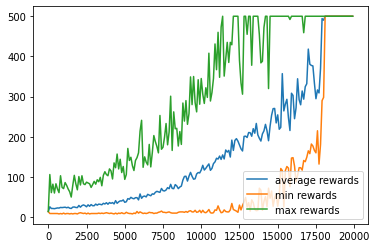

In [ ]:
# Plot graph
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")
plt.plot(metrics['ep'], metrics['min'], label="min rewards")
plt.plot(metrics['ep'], metrics['max'], label="max rewards")
plt.legend(loc=4)
plt.show()


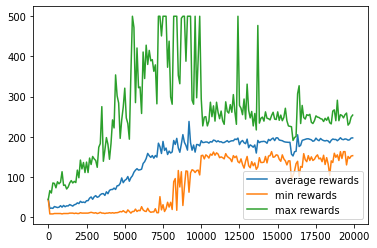

In [ ]:

# Plot graph
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")
plt.plot(metrics['ep'], metrics['min'], label="min rewards")
plt.plot(metrics['ep'], metrics['max'], label="max rewards")
plt.legend(loc=4)
plt.show()


In [ ]:
# criando o ambiente
env = wrap_env(gym.make('CartPole-v1'))
R = 0.0
discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
done = False
while not done:
  env.render()

  action = np.argmax(qTable[discreteState])
  newState, reward, done, info = env.step(action)

  discreteState = get_discrete_state(newState, bins, obsSpaceSize)
  R += reward

print(R)
# Encerra e mostra vídeo do resultado
env.close()
show_video()

500.0


# Fuzzy

In [ ]:
class Fuzzy():
  def __init__(self, a, b, c):
    self.a = a
    self.b = b
    self.c = c
    self.fz = np.array([0, 0, 1, 0, 0])

  def fuzzify(self, x):
    if x < -self.a or x > self.a:
      n = 0
    else:
      n = 1 - abs(x) / self.a
    if x < 0 or x > self.b:
      bp = 0
    else:
      bp = 1 - abs(x-self.a) / (self.b-self.a)
    if x < self.a:
      ap = 0
    elif x > self.b:
      ap = 1
    else:
      ap = (x-self.a) / (self.b-self.a)
    if x > 0 or x < -self.b:
      bn = 0
    else:
      bn = 1 - abs(x+self.a) / (self.b-self.a)
    if x > -self.a:
      an = 0
    elif x < -self.b:
      an = 1
    else:
      an = 1 - (x-self.b) / (self.b-self.a)
    self.fz = np.array([an, bn, n, bp, ap])

  def get(self):
    return self.fz

  def set(self, an, bn, n, bp, ap):
    self.fz = np.array([an, bn, n, bp, ap])

  def defuzzify(self):
    x_an = -self.c
    x_bn = -self.a
    x_n = 0
    x_bp = self.a
    x_ap = self.c
    an, bn, n, bp, ap = self.fz
    s = an+bn+n+bp+ap
    x = (x_an*an + x_bn*bn + x_n*n + x_bp*bp + x_ap*ap) / s
    return x

In [ ]:
class FuzzyController():
  def __init__(self):
    self.ang = Fuzzy(0.05, 0.2, 0.05)
    self.velang = Fuzzy(0.5, 2.0, 5.0)
    self.action = Fuzzy(0.1, 0.5, 1.0)
    
  def compute(self, ang, velang):
    self.ang.fuzzify(ang)
    self.velang.fuzzify(velang)
    aan, abn, an, abp, aap = self.ang.get()
    van, vbn, vn, vbp, vap = self.velang.get()
    ap = max(min(an, van), min(aan, vn))
    bp = max(min(an, vbn), min(abn, vn))
    n = max(min(abp, vbn), min(an, vn), min(abn, vbp))
    bn = max(min(an, vbp), min(abp, vn))
    an = max(min(an, vap), min(aap, vn))
    s = an+bn+n+bp+ap
    if s == 0.0:
      self.action.set(0, 0, 1, 0, 0)
    else:
      self.action.set(an/s, bn/s, n/s, bp/s, ap/s)
    return self.action.defuzzify()

# Rodando o ambiente

In [ ]:
# Cria o ambiente
env = wrap_env(gym.make('CartPole-v1'))

# Cria controlador Fuzzy
fc = FuzzyController()

# Laço principal
done = False
observation = env.reset()
steps = 0
R = 0.0
while not done:
  env.render()
  pos, vel, ang, velang = observation
  action = np.array([-fc.compute(ang, velang)])
  if action<0:
    observation, reward, done, info = env.step(0)
  else:
    observation, reward, done, info = env.step(1)
  R += reward

# Encerra e mostra vídeo do resultado
env.close()
show_video()
print('Total reward:', R)

Total reward: 500.0
